In [1]:
# Standard lib
from typing import List, Dict
import os
import sys
from pathlib import Path
from dataclasses import asdict
from datetime import datetime, timedelta

# 3rd party
import pandas as pd
from pymongo import MongoClient, ASCENDING, DESCENDING
from tqdm import tqdm
import multiprocess as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib import markers
import numpy as np

# Local
project_root = Path.cwd().parent
src_path = str(project_root / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from analysis.remediation import find_image_remediations

# Environment setup
import dotenv
dotenv.load_dotenv(".env", override=True) # Defines MONGO_URI

True

In [4]:
"""
Remediation Analysis Logic
"""

client = MongoClient(os.environ["MONGO_URI"])
db = client["gallery"]
PHASE_1_START = datetime(2024, 3, 28, 4)
PHASE_2_START = datetime(2024, 4, 11, 17)


def fetch_phase_1_images() -> List[Dict]:
    """
    Fetches only the images from phase I.
    Not very efficient but works.
    """
    query = {"scan_start": {"$lt": PHASE_1_START + timedelta(minutes=30)}}
    cursor = db["cves"].find(query)
    images = []
    for doc in cursor:
        image_dict = {
            "registry": doc["registry"],
            "repository": doc["repository"],
            "tag": doc["tag"],
            "labels": doc["labels"]
        }

        if image_dict not in images:
            images.append(image_dict)
    return images


def fetch_phase_1_and_2_images() -> List[Dict]:
    """
    Pull te list of images from mongo.
    """
    return list(db["images"].find({"registry": "cgr.dev"}))


def image_handler(image: dict) -> pd.DataFrame:
    """
    Collects the remediations from an image's scans.
    """
    query = {
        "registry": image["registry"],
        "repository": image["repository"],
        "tag": image["tag"],
    }
    scans = db["cves"].find(query).sort([("scan_start", ASCENDING)])
    rems = find_image_remediations(scans)
    df = pd.DataFrame(map(asdict, rems))
    for col in ["registry", "repository", "tag"]:
        df[col] = image[col]
    df["labels"] = "".join(image["labels"])
    return df


def expand_cve_column(df: pd.DataFrame):
    """
    Helper method that expands the cve column into id, severity, fix_state, ect columns.
    """
    expanded_df = pd.json_normalize(df["cve"])
    return pd.concat([df.drop(columns=["cve"]), expanded_df], axis=1)


def remediation_time_column(df: pd.DataFrame):
    """
    Creates the remediation time column.
    """
    rtime = (df["remediated_at"] - df["first_seen_at"])
    return rtime.dt.total_seconds() / 3600


def first_scan() -> datetime:
    """
    Fetch the latest scan in the dataset.
    """
    last_scan = db["cves"].find_one({}, sort=[("scan_start", ASCENDING)])
    return last_scan["scan_start"]


def latest_scan() -> datetime:
    """
    Fetch the latest scan in the dataset.
    """
    last_scan = db["cves"].find_one({}, sort=[("scan_start", DESCENDING)])
    return last_scan["scan_start"]


def get_label_stats(label: str, df: pd.DataFrame) -> Dict:
    """
    Generate stats for a given label.
    """
    label_df = df[df["labels"].str.contains(label)]
    preexisting_df = label_df[label_df["first_seen_at"].isna()]
    remediated_df = label_df[label_df["first_seen_at"].notna() & label_df["remediated_at"].notna()]
    residual_df = label_df[label_df["remediated_at"].isna()]

    stats = {
        "n_preexisting": preexisting_df.shape[0],
        "n_discovered": label_df.shape[0],
        "n_remediated": remediated_df.shape[0],
        "n_residual": residual_df.shape[0],
        "ave_remediation_time": remediated_df["rtime"].mean() / 24,
        "std_remediation_time": remediated_df["rtime"].std() / 24,
    }

    adj_df = label_df.copy()
    adj_df.loc[adj_df["first_seen_at"].isna(), "first_seen_at"] = first_scan()
    adj_df.loc[adj_df["remediated_at"].isna(), "remediated_at"] = latest_scan()

    adj_df["rtime"] = remediation_time_column(adj_df)
    stats["adj_ave_remediation_time"] = adj_df["rtime"].mean() / 24
    stats["adj_std_remediation_time"] = adj_df["rtime"].std() / 24

    return stats

In [3]:
"""
Phase I Analysis
"""

# Process images
images = fetch_phase_1_images()

with mp.Pool(mp.cpu_count()) as pool:
    dfs = list(tqdm(pool.imap_unordered(image_handler, images),
                    desc=f"Collecting remediations",
                    total=len(images)))
p1_df = pd.concat(dfs, axis=0, ignore_index=True)

# Expand CVE column
p1_df = expand_cve_column(p1_df)

# Create remediation time columns
p1_df["rtime"] = remediation_time_column(p1_df)

# Generate stats
labels = ["cgr-public", "docker-official", "ubi", "mcr", "canonical"]

for l in labels:
    print(l)
    stats = get_label_stats(l, p1_df)
    print(stats)

/tmp/ipykernel_465526/108465044.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  p1_df = pd.concat(dfs, axis=0, ignore_index=True)


cgr-public
{'n_preexisting': 19, 'n_discovered': 41, 'n_remediated': 7, 'n_residual': 15, 'ave_remediation_time': 1.82771117228836, 'std_remediation_time': 1.6229138914245513, 'adj_ave_remediation_time': 7.618632404019873, 'adj_std_remediation_time': 3.8679799648241935}
docker-official
{'n_preexisting': 4107, 'n_discovered': 14146, 'n_remediated': 3090, 'n_residual': 6949, 'ave_remediation_time': 2.775774713502337, 'std_remediation_time': 1.9508809953105513, 'adj_ave_remediation_time': 8.642379061824995, 'adj_std_remediation_time': 3.318473731712588}
ubi
{'n_preexisting': 15530, 'n_discovered': 42750, 'n_remediated': 2186, 'n_residual': 25034, 'ave_remediation_time': 2.627451414334909, 'std_remediation_time': 1.9588279230940815, 'adj_ave_remediation_time': 9.82568571631633, 'adj_std_remediation_time': 2.0170523878598163}
mcr
{'n_preexisting': 40, 'n_discovered': 100, 'n_remediated': 0, 'n_residual': 60, 'ave_remediation_time': nan, 'std_remediation_time': nan, 'adj_ave_remediation_time

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7bbf824901f0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7bbf71394310> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [6]:
"""
Phase II Analysis
"""

# Process images
images = fetch_phase_1_and_2_images()

with mp.Pool(mp.cpu_count()) as pool:
    dfs = list(tqdm(pool.imap_unordered(image_handler, images),
                    desc=f"Collecting remediations",
                    total=len(images)))
p2_df = pd.concat(dfs, axis=0, ignore_index=True)

# Expand CVE column
p2_df = expand_cve_column(p2_df)

# Create remediation time columns
p2_df["rtime"] = remediation_time_column(p2_df)

# Generate stats
labels = ["cgr-public"]

for l in labels:
    print(l)
    stats = get_label_stats(l, p2_df)
    print(stats)

/tmp/ipykernel_465526/2395670892.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  p2_df = pd.concat(dfs, axis=0, ignore_index=True)


cgr-public
{'n_preexisting': 23, 'n_discovered': 61, 'n_remediated': 14, 'n_residual': 26, 'ave_remediation_time': 1.3871538095238092, 'std_remediation_time': 1.3118745158161342, 'adj_ave_remediation_time': 6.753835495787797, 'adj_std_remediation_time': 5.278837447379444}


Text(0.5, 0, 'Days')

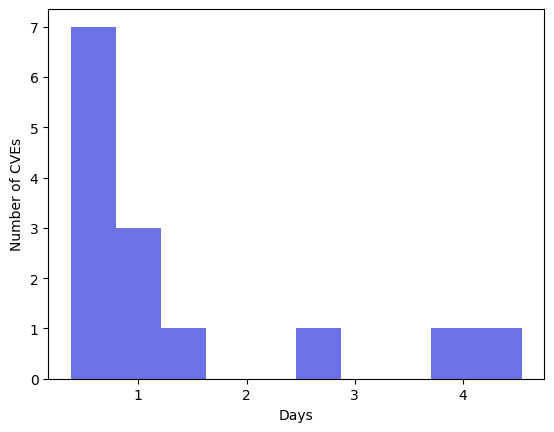

In [13]:
"""
Phase I and II Histogram - True Remediations Only
"""
remediated_df = p2_df[p2_df["first_seen_at"].notna() & p2_df["remediated_at"].notna()]

fig, ax = plt.subplots()
ax.hist(remediated_df["rtime"] / 24, color="#6a72e6")
ax.set_ylabel("Number of CVEs")
ax.set_xlabel("Days")

Text(14.25, 13.15, 'Phase II')

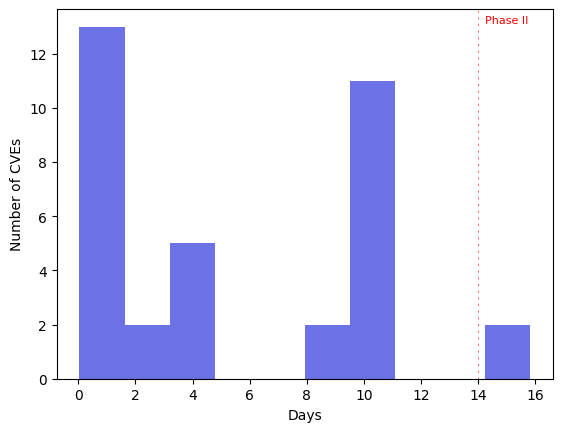

In [21]:
"""
Phase I and II Histogram - Adjusted Remediations Included
"""
adj_remediated_df = p2_df.copy()
adj_remediated_df.loc[adj_remediated_df["first_seen_at"].isna(), "first_seen_at"] = first_scan()
adj_remediated_df.loc[adj_remediated_df["remediated_at"].isna(), "remediated"] = latest_scan()
adj_remediated_df["rtime"] = remediation_time_column(adj_remediated_df)

fig, ax = plt.subplots()
ax.hist(adj_remediated_df["rtime"] / 24, color="#6a72e6")
ax.set_ylabel("Number of CVEs")
ax.set_xlabel("Days")

phase_2_days = (PHASE_2_START - PHASE_1_START).days
ax.axvline(phase_2_days, color="red", linestyle="--", dashes=(4, 8), linewidth=0.4)
ax.text(phase_2_days + 0.25, ax.get_ylim()[1]-0.5, "Phase II", fontsize=8, color="red")

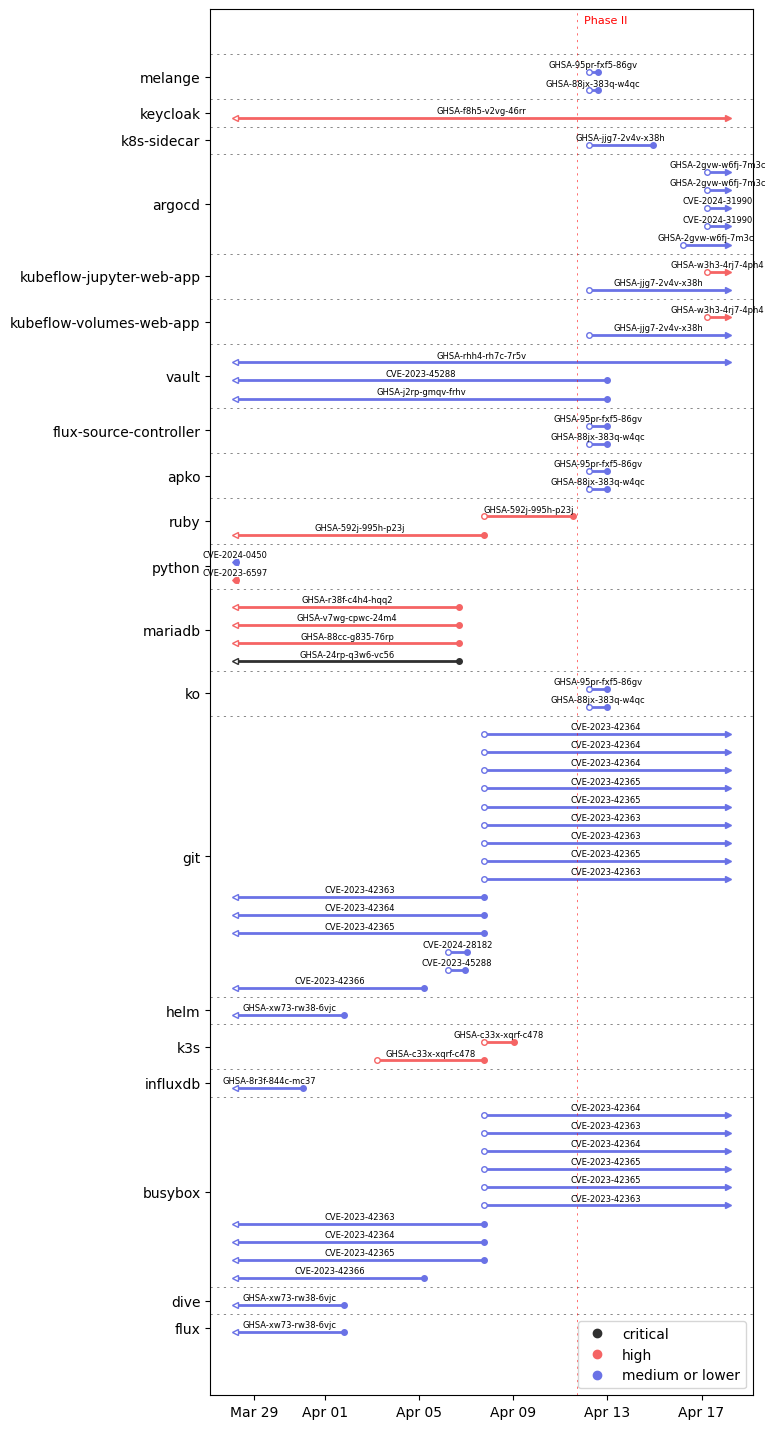

In [25]:
LINE_WIDTH = 2

legend = {
    "critical": "#303030",
    "high": "#f56464",
    "medium or lower": "#6a72e6"
}

def get_line_color(remediation: pd.Series) -> str:
    severity = remediation["severity"]
    if severity in legend.keys():
        return legend[severity]
    return legend["medium or lower"]


def plot_rems_timeseries(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(7, 18))
    y = 0
    hlines = []
    labels_y = []
    labels = []
    x_first = first_scan()
    x_last =  latest_scan()
    for repo in df["repository"].unique():
        remediations = df[df["repository"] == repo]
        start_y = y
        for _, rem in remediations.iterrows():
            start = rem["first_seen_at"]
            if pd.isnull(start):
                start = x_first
            
            end = rem["remediated_at"]
            if pd.isnull(end):
                end = x_last

            color = get_line_color(rem)
            ax.plot([start, end], [y, y], color=color, linewidth=LINE_WIDTH)

            start_marker, end_marker = "o", "o"
            if start == x_first:
                start_marker = "<"
            if end == x_last:
                end_marker = ">"

            ax.plot(start, y, start_marker, mfc="white", mec=color, ms=LINE_WIDTH*2, mew=1)
            ax.plot(end, y, end_marker, mfc=color, mec=color, ms=LINE_WIDTH*2, mew=1)
            id_ = str(rem["id"])
            ax.text(start + ((end - start) / 2), y+0.25, id_, fontsize=6, ha="center")

            y += 1

        hlines.append(y)
        labels_y.append((y + start_y) / 2 - 0.25)
        labels.append(repo[11:])
        y += 0.5
    
    for y in hlines:
        ax.axhline(y, color="#303030", linestyle="--", dashes=(4, 8), linewidth=0.4)
    
    ax.axvline(PHASE_2_START, color="red", linestyle="--", dashes=(4, 8), linewidth=0.4)
    ax.text(PHASE_2_START + timedelta(hours=7), ax.get_ylim()[1]-0.75, "Phase II", fontsize=8, color="red")
    
    ax.set_yticks(labels_y)
    ax.set_yticklabels(labels, fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

    legend_handles = [Line2D([0], [0], color=color, marker="o", linestyle="", label=label)
                  for label, color in legend.items()]
    ax.legend(handles=legend_handles, loc="lower right", fontsize=10)


plot_rems_timeseries(p2_df)